In [20]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
import random
from datetime import datetime

# Настройка стиля графиков
sns.set_style("whitegrid")

In [21]:
def generate_last_12_months():
    today = datetime.today()
    current_year = today.year
    current_month = today.month
    months = []
    for i in range(12):
        year = current_year
        month = current_month - i
        if month <= 0:
            month += 12
            year -= 1
        months.append(f"{year}-{month:02d}")
    months.reverse()
    return months

# Функция для генерации данных о продажах с использованием нормального распределения
def generate_sales_dataframe(models, months):
    data = []
    for model in models:
        mean_sales = random.randint(40, 80)  # Среднее значение продаж
        std_dev_sales = random.uniform(5, 15)  # Стандартное отклонение
        
        for month in months:
            # Генерация продаж с использованием нормального распределения
            sales = max(0, int(np.random.normal(mean_sales, std_dev_sales)))
            data.append({
                'Model': model['name'],
                'Month': month,
                'Sales': sales
            })
    return pd.DataFrame(data)

# парсинг XML-файла
def parse_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    shop = root.find('shop')
    offers = shop.find('offers').findall('offer')

    models = []
    for offer in offers:
        model_id = offer.get('id')
        model_name = offer.find('name').text
        models.append({'id': model_id, 'name': model_name})
    return models

# Путь к XML файлу
xml_file = '../LR6/couches.xml'
models = parse_xml(xml_file)

# Генерация данных о продажах
months = generate_last_12_months()
sales_df = generate_sales_dataframe(models, months)

# Вывод первых строк DataFrame
print("\nПервые строки таблицы продаж:")
display(sales_df.head())


Первые строки таблицы продаж:


,Model,Month,Sales
0,Кресло Pero с подлокотниками FIRST,2024-05,78
1,Кресло Pero с подлокотниками FIRST,2024-06,88
2,Кресло Pero с подлокотниками FIRST,2024-07,69
3,Кресло Pero с подлокотниками FIRST,2024-08,70
4,Кресло Pero с подлокотниками FIRST,2024-09,66


In [22]:
sales_df['Month_Num'] = pd.to_datetime(sales_df['Month']).dt.to_period('M').astype('int64')

models_dict = {}
predictions_dict = {}
r2_scores = {}

for model_name in sales_df['Model'].unique():
    # Фильтруем данные только для текущей модели
    model_data = sales_df[sales_df['Model'] == model_name]
    
    # Разделяем данные на признаки (X) и целевую переменную (y)
    X = model_data[['Month_Num']]
    y = model_data['Sales']
    
    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Создаем и обучаем модель линейной регрессии
    reg_model = LinearRegression()
    reg_model.fit(X_train, y_train)
    
    # Сохраняем модель в словаре
    models_dict[model_name] = reg_model
    
    # Оценка модели на тестовой выборке
    y_pred = reg_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores[model_name] = r2
    
    # Прогноз на следующий месяц
    next_month_num = model_data['Month_Num'].max() + 1
    next_month_sales = reg_model.predict([[next_month_num]])
    predictions_dict[model_name] = {'month_num': next_month_num, 'predicted_sales': next_month_sales[0]}


c:\Users\Altxe\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Altxe\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Altxe\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [23]:
# Выводим результаты прогнозов
print("\nРезультаты прогнозов продаж на следующий месяц:")
for model_name, pred in predictions_dict.items():
    print(f"{model_name}: {pred['predicted_sales']:.2f} (R² = {r2_scores[model_name]:.2f})")

# Создаем DataFrame для прогнозов
predictions_df = pd.DataFrame({
    'Model': list(predictions_dict.keys()),
    'Predicted_Sales': [pred['predicted_sales'] for pred in predictions_dict.values()],
    'R2_Score': [r2_scores[model] for model in predictions_dict.keys()]
})

# Сортируем по прогнозируемым продажам
predictions_df = predictions_df.sort_values('Predicted_Sales', ascending=False)

# Выводим таблицу прогнозов
display(predictions_df)


Результаты прогнозов продаж на следующий месяц:
Кресло Pero с подлокотниками FIRST: 73.20 (R² = -8.37)
Диван Brioche FIRST 2-х местный с широкими подлокотниками: 40.52 (R² = -1.27)
Диван Brioche Premier угловой пр/лев с широкими подлокотниками: 58.91 (R² = -0.68)


,Model,Predicted_Sales,R2_Score
0,Кресло Pero с подлокотниками FIRST,73.203911,-8.366017
2,Диван Brioche Premier угловой пр/лев с широким...,58.909218,-0.680785
1,Диван Brioche FIRST 2-х местный с широкими под...,40.523743,-1.266560


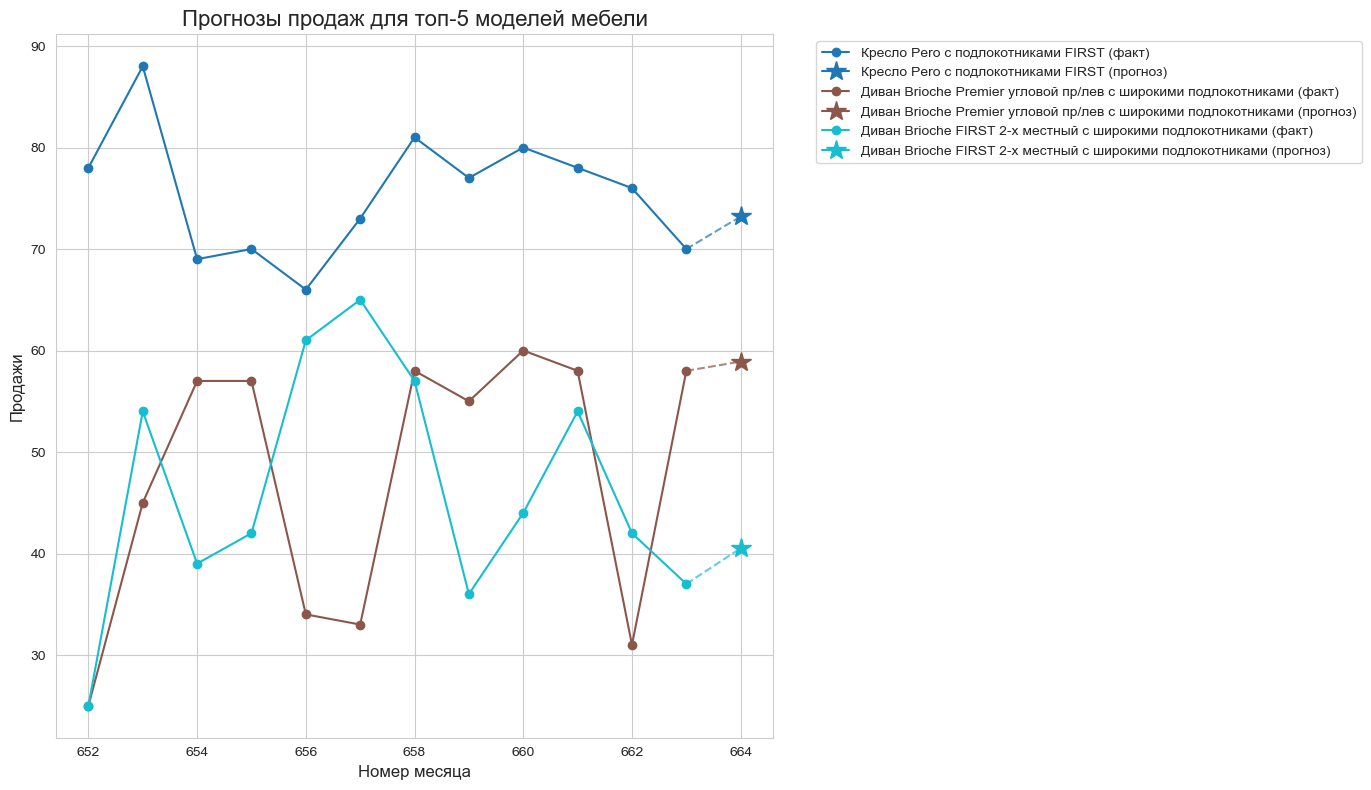

<Figure size 1400x800 with 0 Axes>

In [26]:
# Визуализация прогнозов для каждой модели с помощью линейных графиков
plt.figure(figsize=(14, 8))

# Выбираем топ-5 моделей для визуализации, чтобы график не был перегружен
top_models = predictions_df.head(5)['Model'].values

# Создаем уникальные цвета для каждой модели
colors = plt.cm.tab10(np.linspace(0, 1, len(top_models)))

for i, model_name in enumerate(top_models):
    # Фильтруем данные только для текущей модели
    model_data = sales_df[sales_df['Model'] == model_name]
    
    # Получаем модель и прогноз
    model = models_dict[model_name]
    pred = predictions_dict[model_name]
    
    # Сортируем данные по месяцам для правильного отображения линии тренда
    model_data = model_data.sort_values('Month_Num')
    
    # Строим линию фактических данных
    plt.plot(model_data['Month_Num'], model_data['Sales'], 
             marker='o', linestyle='-', color=colors[i], 
             label=f"{model_name} (факт)")
    
    # Добавляем точку прогноза и соединяем с последней фактической точкой
    last_month = model_data['Month_Num'].max()
    last_sales = model_data[model_data['Month_Num'] == last_month]['Sales'].values[0]
    
    plt.plot([last_month, pred['month_num']], [last_sales, pred['predicted_sales']], 
             linestyle='--', color=colors[i], alpha=0.7)
    
    plt.plot([pred['month_num']], [pred['predicted_sales']], 
             marker='*', markersize=15, color=colors[i], 
             label=f"{model_name} (прогноз)")

plt.title('Прогнозы продаж для топ-5 моделей мебели', fontsize=16)
plt.xlabel('Номер месяца', fontsize=12)
plt.ylabel('Продажи', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
